In [ ]:
# import python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, tqdm # import utility libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.applications import VGG19
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.layers import LSTM, GRU, Conv2D, MaxPooling2D, Dense, Activation, Flatten
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix

In [ ]:
# directory with training covid pictures
train_covid_dir = os.path.join('/content/drive/MyDrive/python csv files/CT_COVID')

# Directory with training human pictures
train_non_covid_dir = os.path.join('/content/drive/MyDrive/python csv files/CT_NonCOVID')

print(train_covid_dir)
print(train_non_covid_dir)

/content/drive/MyDrive/python csv files/CT_COVID
/content/drive/MyDrive/python csv files/CT_NonCOVID


In [ ]:
# print images of covid images
train_covid_names = os.listdir(train_covid_dir)
print(f'TRAIN SET COVID: {train_covid_names[:10]}')

print('')

# print names of non covid images
train_non_covid_names = os.listdir(train_non_covid_dir)
print(f'TRAIN SET NON-COVID: {train_non_covid_names[:10]}')

TRAIN SET COVID: ['2020.02.25.20021568-p23-108%15.png', '2020.02.25.20021568-p23-108%1.png', '2020.03.04.20026005-p12-1946%1.png', '2020.03.04.20031047-p12-81%2.png', '2020.02.26.20027938-p6-80_1%0.png', '2020.03.10.20032136-p34-118_2%0.png', '2020.03.21.20040691-p18-67-4.png', '2020.02.22.20024927-p20-70%0.png', '2020.03.16.20035105-p6-64-1.png', '2020.02.10.20021584-p6-52%1.png']

TRAIN SET NON-COVID: ['174.png', '1702.png', '663.png', '709.png', '921.png', '782.png', '1310.png', '781.png', '3.jpg', '7.jpg']


In [ ]:
# printing total number of images in each directory
print(f'total training covid images: {len(os.listdir(train_covid_dir))}')
print(f'total training non-covid images: {len(os.listdir(train_non_covid_dir))}')

covid = len(os.listdir(train_covid_dir))
non_covid = len(os.listdir(train_non_covid_dir))
print('Total CT-scanned images in dataset: %s' % str(covid + non_covid))

total training covid images: 349
total training non-covid images: 397
Total CT-scanned images in dataset: 746


In [ ]:
data_dir = '/content/drive/MyDrive/python csv files/'
X, Y = 224, 224
BATCH_SIZE = 32

# setting up the data generator for train and validation splits
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                            )


In [ ]:
# test_datagen = ImageDataGenerator(rescale=1/255.0)

training_data = datagen.flow_from_directory(data_dir,
                                    class_mode = "binary",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42
                                    )

validation_data = datagen.flow_from_directory(data_dir,
                                      class_mode = "binary",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 598 images belonging to 3 classes.
Found 148 images belonging to 3 classes.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

def nn_model():
  
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu, 
                     input_shape=(X, Y, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu))
    model.add(MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.4))

    model.add(Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model

model = nn_model()
model

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)       

In [ ]:

# setup an early stopping object for monitoring model performance
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

# setting up the csv logger
logger = CSVLogger('logs.csv', append=True)

# fitting the model to training data and validating on validation data
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=2,
    callbacks=[early_stopping, logger]
)

Epoch 1/2
19/19 [==============================] - 101s 5s/step - loss: -2604.2153 - accuracy: 0.4682 - val_loss: -7281.3193 - val_accuracy: 0.4662
Epoch 2/2
19/19 [==============================] - 24s 1s/step - loss: -78210.1406 - accuracy: 0.4682 - val_loss: -179481.0312 - val_accuracy: 0.4662


In [ ]:
model = Sequential()
vgg19 = VGG19(input_shape=(224, 224, 3),
                      weights='imagenet',
                      include_top=False)

# swtting traimable to false
for layer in vgg19.layers:
    layer.trainable=False

In [ ]:
x = Flatten()(vgg19.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)
model

In [ ]:
# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

In [ ]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

# fitting the model to training data and validating on validation data
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=2,
    callbacks=[logger]
)

Epoch 1/2
19/19 [==============================] - 343s 18s/step - loss: -532.1728 - accuracy: 0.4682 - val_loss: -1621.4902 - val_accuracy: 0.4662
Epoch 2/2
19/19 [==============================] - 344s 18s/step - loss: -3684.6721 - accuracy: 0.4682 - val_loss: -7763.2788 - val_accuracy: 0.4662


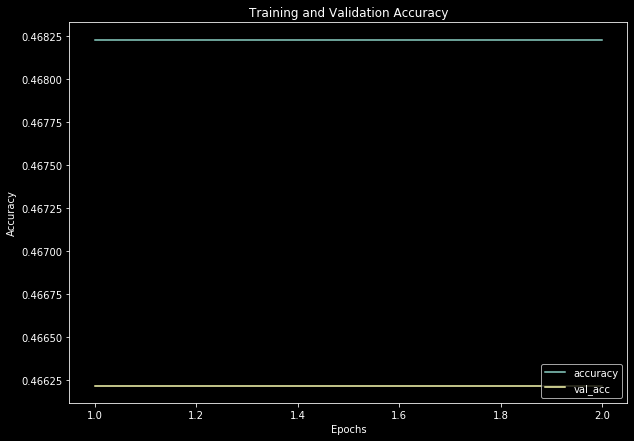

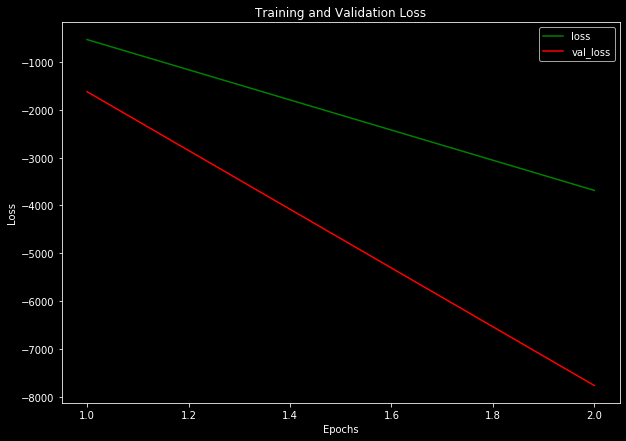

In [ ]:
hist = history.history
plt.style.use('_classic_test_patch')

epochs = range(1, len(hist['loss']) + 1)
acc = hist['accuracy']
loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

# plot loss versus accuracy
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend(loc='lower right')

# plot validation versus accuract
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')


In [ ]:
y_pred = model.predict(training_data)

19/19 [==============================] - 274s 14s/step


In [ ]:
y_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_vgg19.h5')

In [ ]:
img=image.load_img('/content/drive/MyDrive/python csv files/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png',target_size=(224,224))

In [ ]:
model=load_model('model_vgg19.h5')

In [ ]:
x=image.img_to_array(img)
x


array([[[251., 251., 251.],
        [229., 229., 229.],
        [213., 213., 213.],
        ...,
        [ 67.,  67.,  67.],
        [ 73.,  73.,  73.],
        [ 68.,  68.,  68.]],

       [[229., 229., 229.],
        [212., 212., 212.],
        [208., 208., 208.],
        ...,
        [ 72.,  72.,  72.],
        [ 62.,  62.,  62.],
        [ 70.,  70.,  70.]],

       [[219., 219., 219.],
        [211., 211., 211.],
        [209., 209., 209.],
        ...,
        [114., 114., 114.],
        [ 62.,  62.,  62.],
        [ 64.,  64.,  64.]],

       ...,

       [[217., 217., 217.],
        [230., 230., 230.],
        [232., 232., 232.],
        ...,
        [217., 217., 217.],
        [215., 215., 215.],
        [228., 228., 228.]],

       [[197., 197., 197.],
        [208., 208., 208.],
        [224., 224., 224.],
        ...,
        [211., 211., 211.],
        [227., 227., 227.],
        [229., 229., 229.]],

       [[207., 207., 207.],
        [204., 204., 204.],
        [221., 2

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x=x/255

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 1s 587ms/step


array([[1.]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 472ms/step


In [ ]:
if(a==1):
    print("non-covid")
else:
    print("covid")

covid
